In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update({
    "xtick.top": True,
    "ytick.right": True,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "font.size": 12,
    "font.family": "Lato",
    "axes.labelsize": 12,
    "axes.titlesize": 12,
    "legend.fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "xtick.minor.visible": True,
    "ytick.minor.visible": True
    })

In [11]:
from matplotlib import lines as mlines
from math import atan2, degrees

def labelLine(line: mlines.Line2D, x: float, label: str = None, align: bool = True, **kwargs) -> None:
    ax = line.axes
    xdata = line.get_xdata()
    ydata = line.get_ydata()

    # Find corresponding y-coordinate and angle of the line
    ip = 1
    for i in range(len(xdata)):
        if x < xdata[i]:
            ip = i
            break

    if xdata[ip] == xdata[ip - 1]:  # Avoid division by zero
        y = ydata[ip]
    else:
        y = ydata[ip - 1] + (ydata[ip] - ydata[ip - 1]) * (x - xdata[ip - 1]) / (xdata[ip] - xdata[ip - 1])

    if not label:
        label = line.get_label()

    if align:
        # Compute the slope
        dx = xdata[ip] - xdata[ip - 1]
        dy = ydata[ip] - ydata[ip - 1]
        ang = degrees(atan2(dy, dx))

        # Transform to screen coordinates
        pt = np.array([10**x, y]).reshape((1, 2)) if ax.get_xscale() == 'log' else np.array([x, y]).reshape((1, 2))
        trans_angle = ax.transData.transform_angles(np.array([ang]), pt)[0]
    else:
        trans_angle = 0

    # Set a bunch of keyword arguments
    if "color" not in kwargs:
        kwargs["color"] = line.get_color()

    if "horizontalalignment" not in kwargs and "ha" not in kwargs:
        kwargs["ha"] = "center"

    if "verticalalignment" not in kwargs and "va" not in kwargs:
        kwargs["va"] = "center"

    if "backgroundcolor" not in kwargs:
        kwargs["backgroundcolor"] = ax.get_facecolor()

    if "clip_on" not in kwargs:
        kwargs["clip_on"] = True

    if "zorder" not in kwargs:
        kwargs["zorder"] = 2.5

    ax.text(10**x if ax.get_xscale() == 'log' else x, y, label, rotation=trans_angle, **kwargs)

In [125]:
def calculate_air_pressure_altitude(altitude_km, temperature_K):
    # Constants
    P0 = 1.01325  # Pressure at sea level in bar (1 atm)
    g = 9.80665   # Acceleration due to gravity in m/s^2
    M = 0.0289644 # Molar mass of dry air in kg/mol
    R = 8.31447   # Universal gas constant in J/(mol·K)
    
    # Convert altitude from km to meters
    h = altitude_km * 1000
    
    # Calculate pressure using barometric formula
    exponent = (-g * M * h) / (R * temperature_K)
    pressure = P0 * np.exp(exponent)
    
    return pressure

In [127]:
path = "../WebPlotDigitizer/data"
files = os.listdir(path)
dict_ = {}
for file in files:
    dict_[file.split(".")[0]] = pd.read_csv(path + "/" + file, sep=";", decimal=",")

In [128]:
dict_["TP-08Ga"]['pressure'] = calculate_air_pressure_altitude(dict_["TP-08Ga"]['altitude'], dict_["TP-08Ga"]['Temperature'])
dict_["TP-2Ga"]['pressure'] = calculate_air_pressure_altitude(dict_["TP-2Ga"]['altitude'], dict_["TP-2Ga"]['Temperature'])

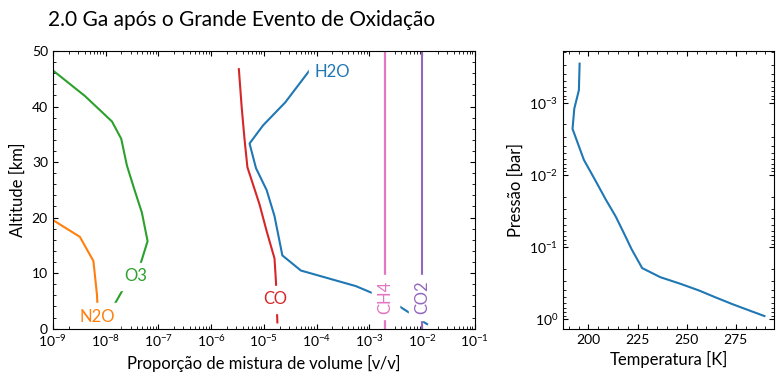

In [135]:
# 2.0 Ga corresponds to the time after the GOE (Great Oxidation Event) 
# of ∼ 2.33 Ga when O2 started to build up in the atmosphere.
fixed_2Ga = {
    "CO2": np.repeat(0.01, 10),
    "O2": np.repeat(0.002, 10),
    "CH4": np.repeat(0.002, 10),
}
altitudes = np.linspace(0, 51, 10)

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(8,4), width_ratios=[3,1.5])
for key, _ in dict_.items():
    if "2Ga" in key:
        molecule = key.split("-")[0]
        if molecule == "TP":
            dict_[key].plot(x="Temperature", y="pressure", ax=ax[1], legend=False)
        else:
            line, = ax[0].plot(dict_[key][molecule], dict_[key]["altitude"])
            x_pos = np.percentile(line.get_xdata(), q=75)
            labelLine(line, x=x_pos, label=molecule, align=False)  

for key, value in fixed_2Ga.items():
    line, = ax[0].plot(value, altitudes, label=key)
    x_median = line.get_xdata()[-1]
    labelLine(line, x=x_median, label=key)  

ax[0].set_xscale("log")
ax[0].axis([1e-9, 1e-1, 0, 50])
ax[0].set(xlabel="Proporção de mistura de volume [v/v]", ylabel="Altitude [km]")
ax[1].set(xlabel="Temperatura [K]", ylabel="Pressão [bar]")
ax[1].set_yscale("log")
ax[1].invert_yaxis()
fig.suptitle("2.0 Ga após o Grande Evento de Oxidação", x=0.07, y=.95, 
             horizontalalignment='left', verticalalignment='top', fontsize = 15)
plt.tight_layout()
plt.show()

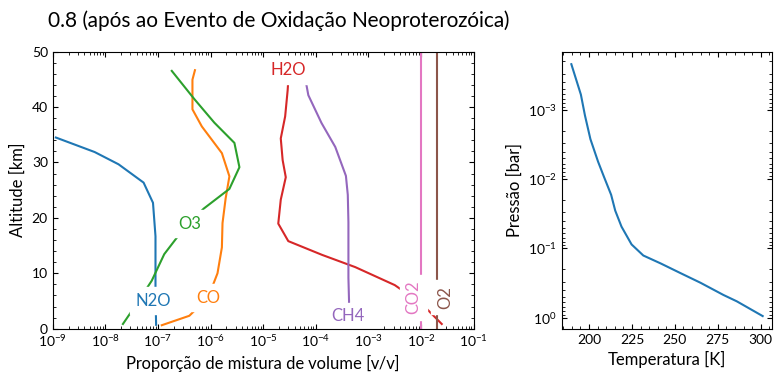

In [134]:
# 0.8 Ga corresponds to the time when multicellular life started to proliferate
# after the NOE (Neoproterozoic Oxidation Event).
fixed_08Ga = {
    "O2": np.repeat(0.020, 10),
    "CO2": np.repeat(0.010, 10),
}
altitudes = np.linspace(0, 51, 10)

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(8,4), width_ratios=[3,1.5])
for key, _ in dict_.items():
    if "08Ga" in key:
        molecule = key.split("-")[0]
        if molecule == "TP":
            dict_[key].plot(x="Temperature", y="pressure", ax=ax[1], legend=False)
        else:
            line, = ax[0].plot(dict_[key][molecule], dict_[key]["altitude"])
            x_pos = np.percentile(line.get_xdata(), q=50)
            labelLine(line, x=x_pos, label=molecule, align=False)  

for key, value in fixed_08Ga.items():
    line, = ax[0].plot(value, altitudes, label=key)
    x_median = np.percentile(line.get_xdata(), q=50)
    if key == "CO2":
        labelLine(line, x=x_median, label=key, horizontalalignment="right")
    else:
        labelLine(line, x=x_median, label=key, horizontalalignment="left")

fig.suptitle("0.8 (após ao Evento de Oxidação Neoproterozóica)", x=0.07, y=.95, 
             horizontalalignment='left', verticalalignment='top', fontsize = 15)
ax[0].set_xscale("log")
ax[0].axis([1e-9, 1e-1, 0, 50])
ax[0].set(xlabel="Proporção de mistura de volume [v/v]", ylabel="Altitude [km]")
ax[1].set(xlabel="Temperatura [K]", ylabel="Pressão [bar]")
ax[1].set_yscale("log")
ax[1].invert_yaxis()
plt.tight_layout()
plt.show()

In [62]:
from scipy.interpolate import make_interp_spline

# Ajuste com B-splines
y_suave = np.linspace(1, 50, 60)
bspline = make_interp_spline(dict_["H2O-08Ga"]["altitude"], dict_["H2O-08Ga"]["H2O"])
y_bspline = bspline(y_suave)

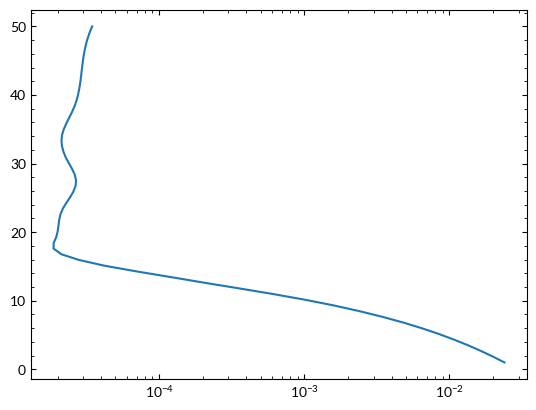

In [66]:
plt.plot(y_bspline, y_suave)
plt.xscale("log")